In [6]:
import numpy as np
import scipy
import pandas as pd
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
from azureml import Workspace

Populating the interactive namespace from numpy and matplotlib


In [7]:
ws = Workspace()
ds = ws.datasets['credit_card_default_analysis.csv']
credit = ds.to_dataframe()

ValueError: workspace_id not provided and not available via config

In [8]:
credit.head(2)

NameError: name 'credit' is not defined

# Задание #1

In [4]:
default = credit[credit.default == 1] #возврат
ndefault = credit[credit.default == 0] #невозврат

### a) гипотеза  равенства медиан

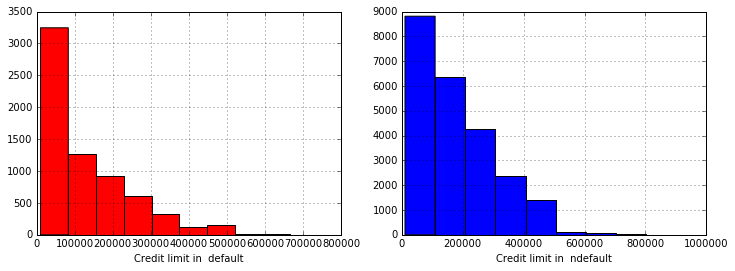

In [5]:
# посмотрим на гистограммы распределений кредитного лимита в двух группах

pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(default.LIMIT_BAL, color = 'r')
pylab.xlabel('Credit limit in  default group')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(ndefault.LIMIT_BAL, color = 'b')
pylab.xlabel('Credit limit in  non-default group')

pylab.show()

Таким образом, кредитный лимит выше в группе, которая вернула кредит, чем в группе, которая кредит не вернула.

Рассчитаем доверительный интервал для разницы медиан в двух выборках на основе бутстрепа.

$H_0\colon$ медианы кредитного лимита совпадают в двух группах заемщиков

$H_1\colon$ медианы кредитного лимита отличаются в двух группах заемщиков

In [246]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [15]:
default_limit = default.LIMIT_BAL.values
ndefault_limit = ndefault.LIMIT_BAL.values

n_samples = 10000

np.random.seed(0)

default_medians = map(np.median, get_bootstrap_samples(default_limit, n_samples))
ndefault_medians = map(np.median, get_bootstrap_samples(ndefault_limit, n_samples))

delta_medians = map(lambda x: x[0]-x[1], zip(default_medianes, ndefault_medians))

print "95% confidence interval for the difference between medians",  stat_intervals(delta_medians, 0.05)

95% confidence interval for the difference between medians [-70000. -60000.]


Как видим из полученной интервальной оценки методом бутстрепа, кредитный лимит в группе "default" на 60-70 тыс. меньше, чем в группе "ndefaut"

### b) проверка равенства распределений 

####Перестановочный критерий

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [251]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [22]:
print "p-value: %f" % permutation_test(default_limit, ndefault_limit, 10000)

p-value: 0.000100


Так как p-value < 0.05, следовательно, нулевая гипотеза отвергается

# Задание 2

### Проверка гипотезы об идентичности  гендерного состава группы людей вернувших и не вернувших кредит 

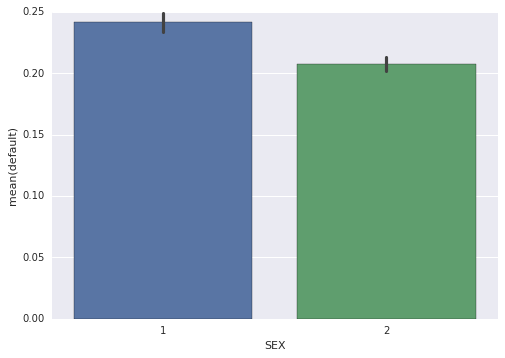

In [48]:
sns.barplot(x = 'SEX',  y = 'default', data = credit)

Таким образом, мужчины чаще не возвращают кредит

Построим доверительный интервал для разницы долей мужчин и женщин в двух группах. 
Воспользуемся формулой и напишем функцию $$p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

In [9]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [253]:
male_def = np.sum(default.SEX.apply(lambda x: 1 if x == 1 else 0))
male_ndef = np.sum(ndefault.SEX.apply(lambda x: 1 if x == 1 else 0))
fem_def = np.sum(default.SEX.apply(lambda x: 1 if x == 2 else 0))
fem_ndef = np.sum(ndefault.SEX.apply(lambda x: 1 if x == 2 else 0))

In [254]:
male = [1]*male_def + [0]*male_ndef
female = [1]*fem_def + [0]*fem_ndef

In [255]:
proportions_confint_diff_ind(male, female)

(0.024207372179792706, 0.043611558570817201)

Доверительный интервал лежит правее нуля, следовательно, гендерный состав не одинаков, мужчины чаще не возвращают кредит

In [16]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

Проверим равенство долей

$H_0: p_1 = p_2$ - доли равны

$H_1: p_1 \neq p_2$ - доли не равны

In [256]:
print 'p-value = ', proportions_diff_z_test(proportions_diff_z_stat_ind(male, female))

p-value =  4.47286652161e-12


Нулевая гипотеза отвергается, гендерный состав в группах различный

# Задание # 3

### Проверка гипотезы о том, что образование не влияет на то, вернет ли человек долг.

In [70]:
cr = credit[:]
cr.EDUCATION[cr.EDUCATION == 6] = np.nan
cr.EDUCATION.dropna(inplace=True)

In [71]:
cr.EDUCATION = cr.EDUCATION.astype('category')
cr.EDUCATION.cat.categories = ['phd', 'master', 'bachelor', 'school', 'preschool', 'other']

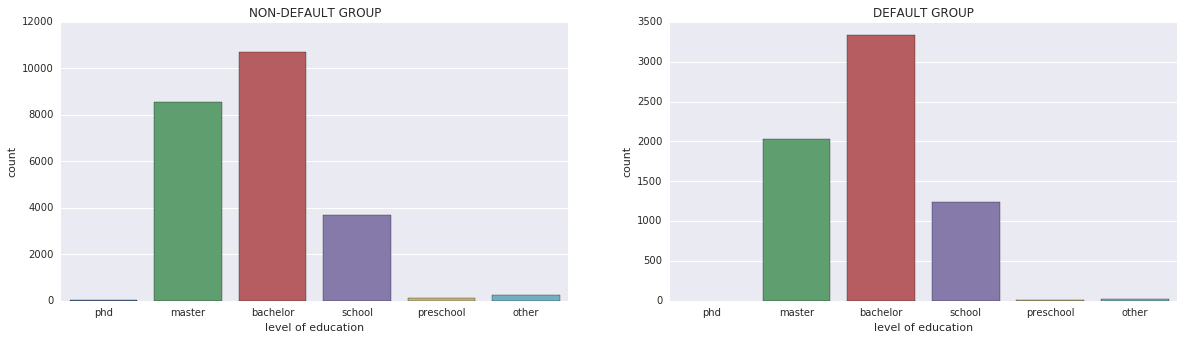

In [72]:
plt.figure(figsize(20,5))
plt.subplot(121)
sns.countplot(x = 'EDUCATION', data = cr[cr.default == 0])
plt.title('NON-DEFAULT GROUP')
plt.xlabel('level of education')
plt.subplot(122)
sns.countplot(x = 'EDUCATION', data = cr[cr.default == 1])
plt.title('DEFAULT GROUP')
plt.xlabel('level of education')
plt.show()

In [297]:
table = list()
for category in cr.EDUCATION.cat.categories:
    x = len(cr[cr.EDUCATION == category].default)
    y = np.sum(cr[cr.EDUCATION == category].default)
    table.append([y,x-y])

In [298]:
table = pd.DataFrame(table, index = cr.EDUCATION.cat.categories, columns=['default', 'non_default'])
table

,default,non_default
phd,0,14
master,2036,8549
bachelor,3330,10700
school,1237,3680
preschool,7,116
other,18,262


Проверим гипотезу об отсутствии зависимости между уровнем образования и возвратом/невозвратом кредита

$H_0:$ возврат кредита не зависит от уровня образования

$H_1:$ возврат кредита зависит от уровня образования

Проверим условия применимости критерия $\chi^2$

In [110]:
n_iplus = np.sum(table, axis = 1)
n_jplus = np.sum(table, axis = 0)
n = sum(n_jplus)

In [113]:
stats = list()
for i in range(len(n_iplus)):
    for j in range(len(n_jplus)):
        stat = n_iplus[i]*n_jplus[j]/n
        stats.append(stat)

In [134]:
print 'Количество наблюдения равно {0}'.format(n)
print 'Количество ячеек, ожидаемое значение которых меньше 5 составляют {0}%'.\
format(float(len([x for x in stats if x < 5]))/ len(stats) * 100)

Количество наблюдения равно 29949
Количество ячеек, ожидаемое значение которых меньше 5 составляют 8.33333333333%


In [299]:
print 'p-value =', scipy.stats.chi2_contingency(table)[1]

p-value = 3.83555441089e-33


Нулевая гипотеза об отсутствии зависимости между уровнем образования и вероятностью возврата кредита не принимается, зависимость имеется

### Представление практической значимости разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг

In [327]:
q = (table - scipy.stats.chi2_contingency(table)[3])/scipy.stats.chi2_contingency(table)[3]

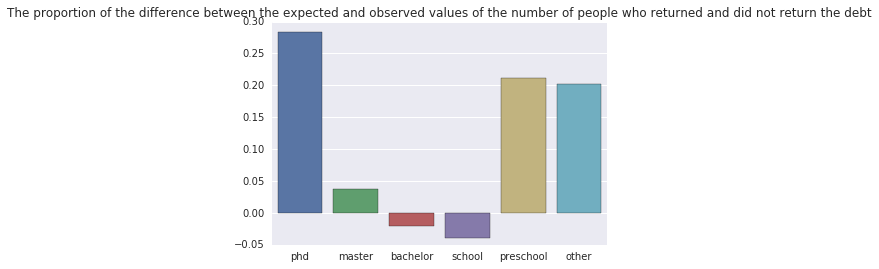

In [328]:
sns.barplot(x=['phd', 'master', 'bachelor', 'school', 'preschool', 'other'], y=q.ix[:,1].values)
plt.title('The proportion of the difference between the expected and observed values of the number of people who returned and did not return the debt')
plt.show()

In [269]:
table = list()
for category in cr.EDUCATION.cat.categories:
    total_n = len(cr[cr.EDUCATION == category].default)
    default_n = np.sum(cr[cr.EDUCATION == category].default)
    table.append([proportion_confint(default_n, total_n)[0],proportion_confint(default_n, total_n)[1]])

In [270]:
table = pd.DataFrame(table, index = cr.EDUCATION.cat.categories, columns=['MIN', 'MAX'])
table

,MIN,MAX
phd,0.000000,0.000000
master,0.184839,0.199856
bachelor,0.230308,0.244389
school,0.239448,0.263705
preschool,0.015969,0.097853
other,0.035558,0.093013


### Наличие какого образования является наилучшим индикатором того, что человек отдаст долг

Как видно из полученных результатов, доля невозвратов выше у тех, кто окончил школу, затем идут те, кто закончил только бакалавриат. Вероятность того, что человек, имеющий степень доктора, вернет кредит очень высока.

# Задание # 4

### Семейный статус заемщика и индикатор дефолта

In [150]:
credit.MARRIAGE = credit.MARRIAGE.astype('category')
credit.MARRIAGE.cat.categories = ['denied', 'married', 'single', 'no_data']

In [ ]:
data[np.logical_and(data.MARRIAGE!='Refuse',data.MARRIAGE!='NA')]

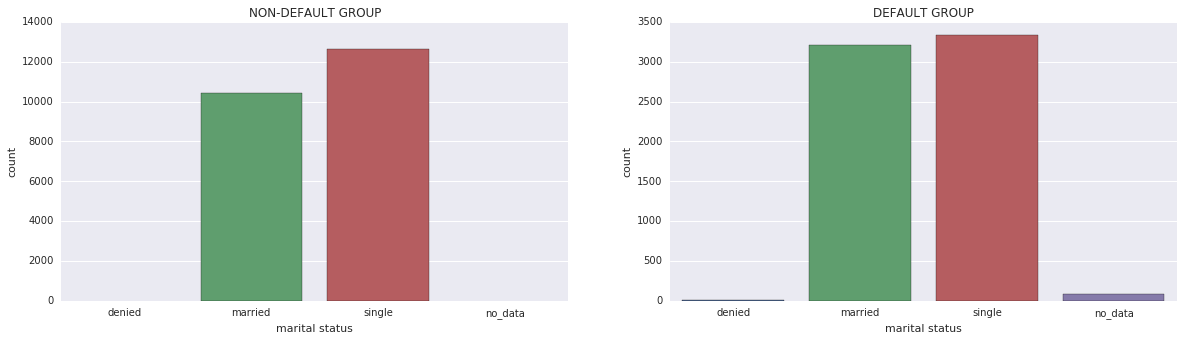

In [185]:
plt.figure(figsize(20,5))
plt.subplot(121)
sns.countplot(x = 'MARRIAGE', data = credit[credit.default == 0])
plt.title('NON-DEFAULT GROUP')
plt.xlabel('marital status')
plt.subplot(122)
sns.countplot(x = 'MARRIAGE', data = credit[credit.default == 1])
plt.title('DEFAULT GROUP')
plt.xlabel('marital status')
plt.show()

Для проверки наличия зависимости между семейным статусом и статусом дефолта воспользуемся критерием Крамера.

In [289]:
table_mar = list()
for category in credit.MARRIAGE.cat.categories:
    x = len(credit[credit.MARRIAGE == category].default)
    y = np.sum(credit[credit.MARRIAGE == category].default)
    table_mar.append([y,x-y])
    
pd.DataFrame(table_mar, credit.MARRIAGE.cat.categories, columns = ['default', 'non_default'])

,default,non_default
denied,5,49
married,3206,10453
single,3341,12623
no_data,84,239


Проверим условия применимости критерия $\chi^2$

In [284]:
n_iplus = np.sum(table_mar, axis = 1)
n_jplus = np.sum(table_mar, axis = 0)
n = sum(n_jplus)

stats = list()
for i in range(len(n_iplus)):
    for j in range(len(n_jplus)):
        stat = n_iplus[i]*n_jplus[j]/n
        stats.append(stat)

In [285]:
print 'Количество наблюдения равно {0}'.format(n)
print 'Количество ячеек, ожидаемое значение которых меньше 5 составляют {0}%'.\
format(float(len([x for x in stats if x < 5]))/ len(stats) * 100)

Количество наблюдения равно 30000
Количество ячеек, ожидаемое значение которых меньше 5 составляют 0.0%


Условия выполняются, критерий применим

Посчитаем коэффициент корреляции и оценим его значимость

$H_0: \phi(X_1,X_2) = 0$ - кореляция отсутствует

$H_1: \phi(X_1,X_2)  \neq 0$ - кореляция присутствует


In [293]:
print 'Коэффициент корреляции Крамера равен = {0}'.format(np.sqrt(scipy.stats.chi2_contingency(table_mar)[0]/len(credit.MARRIAGE)))
print 'p-value =', scipy.stats.chi2_contingency(table_mar)[1]

Коэффициент корреляции Крамера равен = 0.0344782036628
p-value = 8.82586245758e-08


Соответственно, существует слабая положительная связь между семейным статусом невыплатой кредита.
Нулевая гипотеза об отсутствии зависимости между семейным статусом и вероятностью возврата кредита не принимается, зависимость есть

# Задание # 5

### a) проверка гипотезы о равенстве медианных значений возрастов людей в двух группах

Посмотрим на гистограммы распределений возраста в двух группах

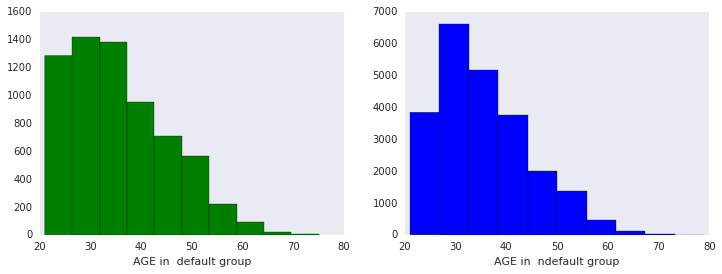

In [243]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(default.AGE, color = 'g')
pylab.xlabel('AGE in  default group')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(ndefault.AGE, color = 'b')
pylab.xlabel('AGE in  ndefault group')

pylab.show()

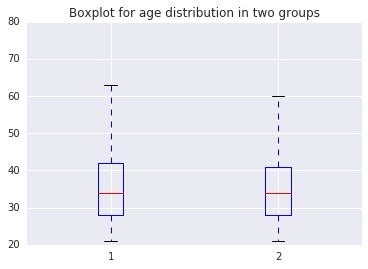

In [245]:
plt.boxplot([default.AGE, ndefault.AGE])
plt.title("Boxplot for age distribution in two groups")
plt.show()

Рассчитаем доверительный интервал для разницы медиан возраста в двух выборках на основе бутстрепа.

$H_0\colon$ медианы возраста совпадают в двух группах заемщиков

$H_1\colon$ медианы возраста отличаются в двух группах заемщиков

In [247]:
default_age = default.AGE.values
ndefault_age = ndefault.AGE.values

n_samples = 10000

np.random.seed(0)

default_medians = map(np.median, get_bootstrap_samples(default_age, n_samples))
ndefault_medians = map(np.median, get_bootstrap_samples(ndefault_age, n_samples))

delta_medians = map(lambda x: x[0]-x[1], zip(default_medians, ndefault_medians))

print "95% confidence interval for the difference between medians",  stat_intervals(delta_medians, 0.05)

95% confidence interval for the difference between medians [ 0.  1.]


### b) проверка гипотезы о равенстве распределений в двух группах

 Перестановочный критерий

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$ - Распределения равны

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$ - Распределения различны

In [252]:
print "p-value: %f" % permutation_test(default_age, ndefault_age, 10000)

p-value: 0.016200


Нулевая гипотеза о равенстве распределения на уровне значимость 0,05 не принимается, распределения различны

### Значимы ли полученные результаты с практической точки зрения

Так как доверительный интервал разности медиан содержит ноль, то мы не можем говорить о различиях в медиане возраста в двух группах, однако сами распределения возрастов различны, что с практической точки зрения значимо, так как с возрастом меняется доход, прочих факторах вероятность возврата выше.